In [1]:
#load in iteration models from 10 folds
#load in iteration models from 5 iterations
import os
import json
from meld_classifier.network_tools import build_model
from meld_classifier.experiment import get_subject_ids
import meld_classifier.hdf5_io as io
import meld_classifier.paths as paths
import numpy as np
import seaborn as sns


Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/kw350


In [20]:
experiments_folder = '/home/kw350/rds/rds-kw350-meld/experiments/kw350/'
experiments_folder = '/rds/project/kw350/rds-kw350-meld/experiments/kw350/'
experiment = 'network_type'
date='20-11-13'

In [21]:
def get_n_features(data_parameters,features):
        """considers universal_features, self.features, and neighbours"""
        # features
        n_features = len(features)
        # universal features
        preloaded_features = io.load_universal_features(data_parameters['universal_features'])
        if preloaded_features is not None:
            n_features += preloaded_features.shape[-1]
        # neighbours
        n_features = n_features * (data_parameters['num_neighbours']+1)
        return n_features

In [22]:
fold=0
iteration=0
experiment_path=os.path.join(experiments_folder,f'{experiment}_{date}',f'fold_{fold}')
experiment_name=f'iteration_{iteration}'
experiment_name='network_type_neighbour'

data_parameters = json.load(open(os.path.join(experiment_path, 'data_parameters_{}.json'.format(experiment_name))))
network_parameters= json.load(open(os.path.join(experiment_path, 'network_parameters_{}.json'.format(experiment_name))))
listids, l_features = get_subject_ids(data_parameters, verbose=False)
n_features = get_n_features(data_parameters,l_features)
checkpoint_path=os.path.join(experiment_path,"models",experiment_name)
model=build_model(
              n_features=n_features//(data_parameters['num_neighbours']+1),
              n_neighbours=data_parameters['num_neighbours'],
              **network_parameters)
#model.load_weights(checkpoint_path)


In [23]:
def load_predict_model(data_dictionary,fold,iteration):
    experiment_path=os.path.join(experiments_folder,f'{experiment}_{date}',f'fold_{fold}')
    #experiment_name=f'iteration_{iteration}'
    experiment_name='network_type_neighbour'
    data_parameters = json.load(open(os.path.join(experiment_path, 'data_parameters_{}.json'.format(experiment_name))))
    network_parameters= json.load(open(os.path.join(experiment_path, 'network_parameters_{}.json'.format(experiment_name))))
    listids, features = get_subject_ids(data_parameters, verbose=False)
    n_features = get_n_features(data_parameters,features)
    checkpoint_path=os.path.join(experiment_path,"models",experiment_name)
    model=build_model(
                  n_features=n_features//(data_parameters['num_neighbours']+1),
                  n_neighbours=data_parameters['num_neighbours'],
                  **network_parameters)
    model.load_weights(checkpoint_path)
    for subject in data_dictionary.keys():
        features=data_dictionary[subject]['input_features']
        prediction = model.predict(features, batch_size=data_parameters['batch_size'])
        data_dictionary[subject][f'prediction_f{fold}_i{iteration}']=prediction
    return

In [15]:
import meld_classifier.mesh_tools as mt

surf = mt.load_mesh_geometry(os.path.join(paths.BASE_PATH,'fsaverage_sym','surf','lh.inflated'))
neighbours = mt.get_neighbours_from_tris(surf['faces'])
selected_neighbours = np.array([neigh[:data_parameters['num_neighbours']] for neigh in neighbours])


In [7]:
subject_ids=data_parameters['val_ids'][:5]

In [8]:
cortex=os.path.join(paths.BASE_PATH,'fsaverage_sym','label','lh.cortex.label')
data_dictionary={}
for subject in subject_ids:
            features, labels = io.load_subject_combined_hemisphere_data(subject, 
                                                                        l_features, 
                                                                        cortex=cortex, 
                                                                        normalise=data_parameters['normalise'],
                                                                       hdf5_file_root=data_parameters['hdf5_file_root'],
                                                                       neighbours=selected_neighbours,
                                                                        preloaded_features = None)
#             data_dictionary[subject] = {
#                 'input_labels': labels,
#                 'result': np.reshape(prediction,len(prediction))
#             }
            data_dictionary[subject]={}
            data_dictionary[subject]['input_features'] = features
            

In [24]:
for f in [0,7]:
    i=0
    load_predict_model(data_dictionary=data_dictionary,fold=f,iteration=i)


In [25]:
#check maximum value per subject in one prediction space
f=7
for subject in subject_ids:
    print(np.min(data_dictionary[subject][f'prediction_f{f}_i0']),
    np.max(data_dictionary[subject][f'prediction_f{f}_i0']))

0.29445574 0.7231412
0.35417283 0.61750597
0.3549705 0.70269656
0.31366247 0.8271612
0.30795085 0.76679033


In [11]:
fold_predictions_dict={}
for f in np.arange(10):
    for i in np.arange(6):
        fold_predictions=[]
        for subject in data_dictionary.keys():
            fold_predictions.extend(list(data_dictionary[subject][f'prediction_f{f}_i{i}'].ravel()))
        fold_predictions_dict[f'fold_{f}_i_{i}']=np.array(fold_predictions)
    


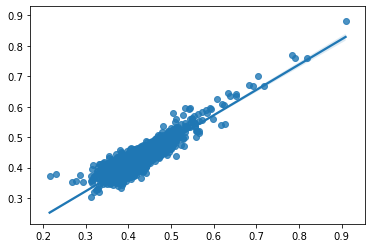

In [12]:
vec=np.random.choice(len(fold_predictions_dict['fold_0_i_1']),size=5000)
sns.regplot(fold_predictions_dict['fold_4_i_1'][vec],fold_predictions_dict['fold_6_i_1'][vec])


In [13]:
grid=np.zeros((6,10,10))
for i in np.arange(6):
    for p in np.arange(10):
        for fold in np.arange(10):
            grid[i,p,fold]=np.corrcoef(fold_predictions_dict[f'fold_{p}_i_{i}'][vec],fold_predictions_dict[f'fold_{fold}_i_{i}'][vec])[0,1]
            
            

In [14]:
#average predictions across iterations
cross_i={}
for i in np.arange(6):
    for subject in data_dictionary.keys():
        cross_i[subject]=np.zeros((10,293804))
        for fold in np.arange(10):
            cross_i[subject][fold]+=data_dictionary[subject][f'prediction_f{fold}_i{i}'].ravel()/6

In [15]:
np.corrcoef(cross_i[subject])

array([[1.        , 0.85328145, 0.84311125, 0.60595141, 0.86062958,
        0.80968005, 0.85916086, 0.77725229, 0.83934067, 0.82724355],
       [0.85328145, 1.        , 0.90923472, 0.6670837 , 0.9132995 ,
        0.85169778, 0.90120451, 0.85660892, 0.87524562, 0.86125279],
       [0.84311125, 0.90923472, 1.        , 0.64634577, 0.91083798,
        0.85601481, 0.88435584, 0.84141678, 0.87534399, 0.87667397],
       [0.60595141, 0.6670837 , 0.64634577, 1.        , 0.6375172 ,
        0.71738082, 0.65405706, 0.59769832, 0.62789226, 0.57238068],
       [0.86062958, 0.9132995 , 0.91083798, 0.6375172 , 1.        ,
        0.87693842, 0.89435166, 0.8491481 , 0.87912522, 0.86808264],
       [0.80968005, 0.85169778, 0.85601481, 0.71738082, 0.87693842,
        1.        , 0.84596996, 0.81836334, 0.81291337, 0.79224654],
       [0.85916086, 0.90120451, 0.88435584, 0.65405706, 0.89435166,
        0.84596996, 1.        , 0.80428944, 0.87601463, 0.85964736],
       [0.77725229, 0.85660892, 0.8414167

In [16]:
fold_predictions_dict_m={}
for f in np.arange(10):
    fold_predictions=[]
    for subject in data_dictionary.keys():
            fold_predictions.extend(list(cross_i[subject][f].ravel()))
    fold_predictions_dict_m[f]=np.array(fold_predictions)

In [17]:
m_grid=np.zeros((10,10))
#vec=np.random.choice(len(fold_predictions_dict['fold_0_i_1']),size=100000)

for p in np.arange(10):
        for fold in np.arange(10):
            m_grid[p,fold]=np.corrcoef(fold_predictions_dict_m[p][:],fold_predictions_dict_m[fold][:])[0,1]
      

In [18]:
meangrid=np.mean(grid,axis=0)

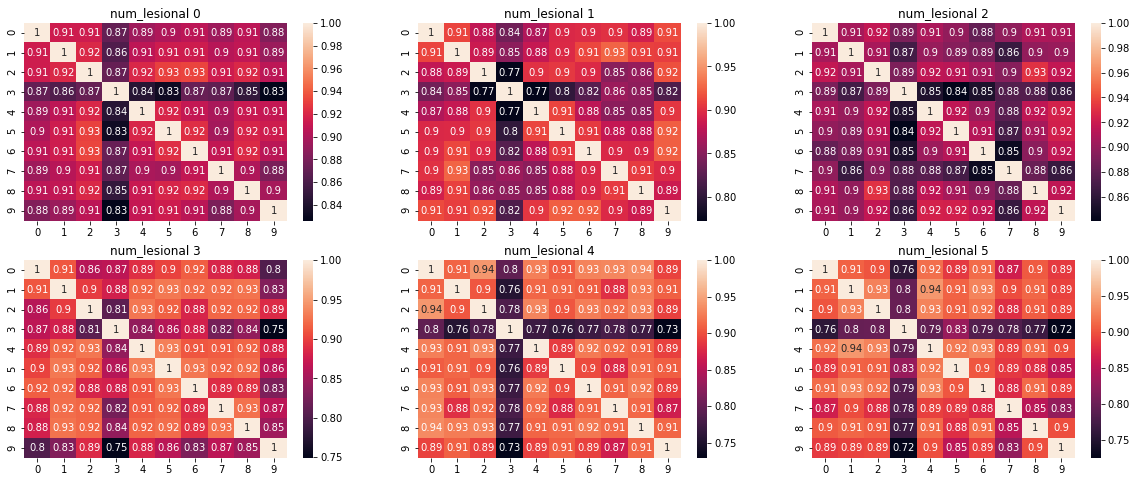

In [21]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(14,8))
fig, axs = plt.subplots(2,3,figsize=(20,8))
for i in np.arange(6):
    
    sns.heatmap(grid[i],annot=True,ax=axs.ravel()[i])
    axs.ravel()[i].set_title('num_lesional {}'.format(i))

Text(0.5, 1, 'num_lesional averaged predictions')

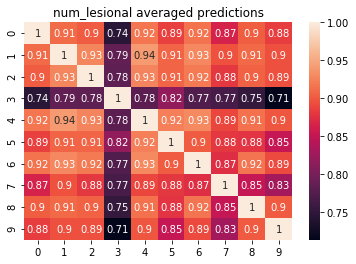

In [22]:
import matplotlib.pyplot as plt
sns.heatmap(m_grid,annot=True)
plt.title('num_lesional averaged predictions')

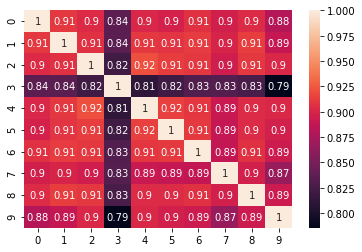

In [23]:
sns.heatmap(meangrid,annot=True)
#check against other iterations for fold 6

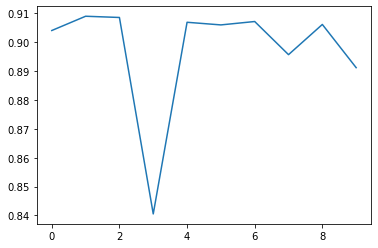

In [24]:
plt.plot(np.mean(meangrid,axis=0))

In [ ]:
#r values vs fold 6 for each ??